In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/deep_face

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/deep_face


# Variational Autoencoder (VAE)

This is a generative model, which could learn the underlying features of a dataset, and generate new data that has the similar features.

![](https://raw.githubusercontent.com/depplenny/deep_face/master/imgs/vae.png)

Encoder outputs mean and  diagonal covariance vector
$$\mu=\mu(x,\phi), \quad \Sigma=\Sigma(x,\phi)=diag(\sigma_1^2, \sigma_2^2, ...),$$
Then a latent vector (low dimensional representation) is
$$z=\mu+\Sigma^{1/2} \odot \epsilon.$$

Suppose that the random variable $z$ with probability density function (PDF) $f_z$ and cumulative distribution fucntion (CDF) $F_z$, **Inverse Transform Sampling** tells us that $z=F_z^{-1}(\epsilon)$ with $\epsilon\sim U(0,1)$. The encoder is approximating the fucntion $F_z^{-1}$.

Decder reconstructs the input
$$\hat{x}=\hat{x}(z,\theta),$$
where $\phi$ and $\theta$ are trainable weights.

For this network, we define the loss as

1. **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence,
$$L_{KL} = \frac{1}{2}\sum\limits_{j=0}^{k-1}\small{(\sigma_j^2 + \mu_j^2 - 1 - \log{\sigma_j^2})}.$$
2. **Reconstruction loss ($L_x$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output,
$$L_{x} = ||x-\hat{x}||_1.$$   

Thus for the VAE loss we have: 

$$L_{VAE} = c\cdot L_{KL} + L_{x},$$

where $c$ is a weighting coefficient used for regularization. 

![Faces](https://media1.tenor.com/images/44e1f590924eca94fe86067a4cf44c72/tenor.gif?itemid=3394328)

## Setup enviroment

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

TensorFlow 2.x selected.


## Images

In [3]:
import util
# Get the training dataset, which includes faces (CelebA Dataset) and objects (ImageNet), we will be only using faces
loader = util.TrainingDatasetLoader('data/train_data.h5')

Opening data/train_data.h5
Loading data into memory...


In [0]:
number_of_training_examples = loader.get_dataset_size() # 109914
# labels is either 1 or 0, i.e. face or non face
(images, labels, inds) = loader.get_batch(100, only_faces=True, return_inds=True)

In [5]:
print('Input shape: ', images.shape)

Input shape:  (100, 64, 64, 3)


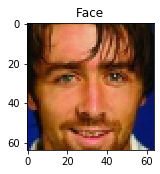

In [6]:
### Examining the training dataset ###

face_images = images[np.where(labels==1)[0]]
#non_face_images = images[np.where(labels==0)[0]]

idx_face = 26 #@param {type:"slider", min:0, max:50, step:1}
#idx_non_face = 37 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))

plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

#plt.subplot(1, 2, 2)
#plt.imshow(non_face_images[idx_non_face])
#plt.title("Not Face"); plt.grid(False)

## Encoder

We will use a CNN as our encoder  which takes as input the images. It outputs mean and sigma (actually $\log\sigma^2$). Those are the parameters that determine inverse CDF of latent variable $z$.

In [0]:
n_filters = 12 # base number of convolutional filters
# Defining the encoder network
def build_encoder(n_outputs):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2, input_shape= (64, 64, 3)),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

In [8]:
build_encoder(100).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 12)        912       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 12)        48        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 24)        7224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 24)        96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 48)          10416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 72)          3

## Decoder

The decoder network will take as input the sampled latent variable, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [0]:
n_filters = 12 # base number of convolutional filters, same as encoder
# Defining the decoder network
def build_decoder():
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

## VAE
Here, we will define the core VAE architecture by sublassing the `Model` class; defining encoding, reparameterization, and decoding operations; and calling the network end-to-end.

In [0]:
# Defining and creating the VAE network
def sampling(mean, logsigma):
  # mean: mean vector
  # logsigma: log(sigma^2)
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch_size, latent_dim = mean.shape
  epsilon = tf.random.normal(shape=(batch_size, latent_dim))
  z = mean + tf.math.exp(0.5 * logsigma) * epsilon
  return z

class VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    # recall that the number of outputs for the encoder is 2*self.latent_dim, because one z corrosponds to one mu and one sigma  
    self.encoder = build_encoder(2*self.latent_dim)
    self.decoder = build_decoder()
  
  # function to feed images into encoder, encode the latent space 
  def encode(self, x):
    encoder_output = self.encoder(x)
    mean = encoder_output[:, :self.latent_dim]
    logsigma = encoder_output[:, self.latent_dim:]
    return mean, logsigma

  # given a mean and logsigma, sample latent variables
  def reparameterize(self, mean, logsigma):
    # Call the sampling function defined above
    z = sampling(mean, logsigma)
    return z
    
  # decode the latent space and output reconstruction
  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  # override the call function, which will be called by __call__()
  def call(self, x): 
    # feed images to encoder
    mean, logsigma = self.encode(x)
    # reparameterize the outputs of encoder
    z = self.reparameterize(mean, logsigma)
    # feed latent variables to decoder
    x_recon = self.decode(z)

    return mean, logsigma, z, x_recon

vae = VAE(latent_dim=100)

## VAE loss

In [0]:
# VAE loss function

''' 
Function to calculate VAE loss given:
  an input: x, 
  reconstructed input: x_recon, 
  encoded mean vector: mu, 
  encoded covariance vector: logsigma, 
  weight parameter for the latent loss: kl_weight.
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.001):
  # mean vector and covariance vector are constrained to roughly follow Gaussian distributions
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return tf.reduce_mean(vae_loss, axis=0)

## Training the VAE

  0%|          | 0/1099 [00:00<?, ?it/s]

 Starting epoch 6/6


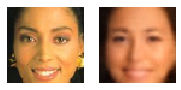

  0%|          | 2/1099 [00:00<01:03, 17.35it/s]

 loss:  0.07015202



 45%|████▍     | 492/1099 [00:05<00:07, 80.88it/s]

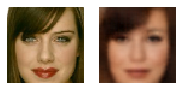

 46%|████▋     | 510/1099 [00:06<00:08, 73.20it/s]

 loss:  0.06950667



 91%|█████████ | 998/1099 [00:11<00:01, 85.11it/s]

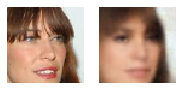

 92%|█████████▏| 1016/1099 [00:12<00:01, 75.42it/s]

 loss:  0.06732967



100%|██████████| 1099/1099 [00:13<00:00, 78.78it/s]


In [106]:
# Training the VAE

# Hyperparameters
batch_size = 100
learning_rate = 5e-4
num_epochs = 6  
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = []
checkpoint_dir = './training_checkpoints'
checkpoint_name = os.path.join(checkpoint_dir, "ckpt_{epoch}.h5")

@tf.function
def train_step(x):
  # Create a tape to record loss
  with tf.GradientTape() as tape:
    # Feed input x into VAE. Note that this is using the VAE's call function!
    mean, logsigma, z, x_recon = vae(x)
    # call the VAE loss function to compute the loss.
    loss = vae_loss_function(x, x_recon, mean, logsigma, kl_weight=0.0001)  
  # use the GradientTape.gradient method to compute the gradients
  grads = tape.gradient(loss, vae.trainable_variables)
  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, vae.trainable_variables))

  return loss

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop
for epoch in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print(" Starting epoch {}/{}".format(epoch+1, num_epochs))
  
  for step in tqdm(range(loader.get_dataset_size()//batch_size)):
    # load a batch of data
    x, _ = loader.get_batch(batch_size, only_faces=True)
    # loss optimization
    loss = train_step(x)
    # plot the progress every 500 steps
    if step % 500 == 0: 
      util.plot_sample(x, vae)
      loss_history.append(loss.numpy())
      print(" loss: ",loss.numpy())
      print()
  
  vae.save_weights(checkpoint_name.format(epoch=epoch))

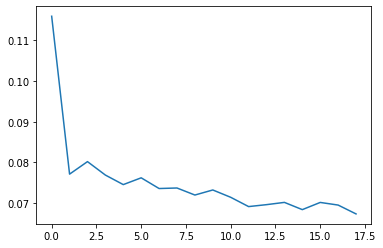

In [107]:
plt.plot(loss_history)

In [0]:
x, _ = loader.get_batch(batch_size, only_faces=True)


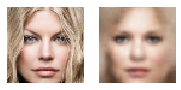

In [109]:
util.plot_sample(x, vae, idx=4)

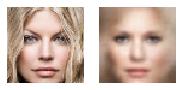

In [110]:
util.plot_sample(x, vae, idx=4)

## Perturbation of latent variables

In [0]:
# vae.load_weights(checkpoint_name.format(epoch=5))

In [0]:
 x, _ = loader.get_batch(50, only_faces=True)
mean, logsigma = vae.encode(x)
z = vae.reparameterize(mean, logsigma)
imgae_idx = 1   # Change Image

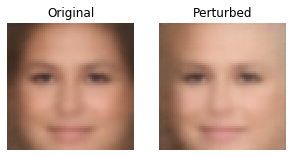

In [105]:
my_z=z.numpy()  
my_z[imgae_idx]=z[imgae_idx]+1.
my_z=tf.constant(my_z)
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
x_recon = vae.decode(z)
x_recon = np.clip(x_recon, 0, 1)
plt.imshow(x_recon[imgae_idx])
plt.grid(False)
plt.axis('off')
plt.title('Original')
plt.subplot(1, 2, 2)
x_recon = vae.decode(my_z)
x_recon = np.clip(x_recon, 0, 1)
plt.imshow(x_recon[imgae_idx])
plt.grid(False)
plt.axis('off')
plt.title('Perturbed')
plt.show()